# Advanced Lane Lines

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

from image_functions import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Get camera matrix from calculated result

In [2]:
with open('camera_matrix.pkl', 'rb') as file:
    data = pickle.load(file)
    mtx = data[0]
    dist = data[1]

## Apply distortion correction to test images

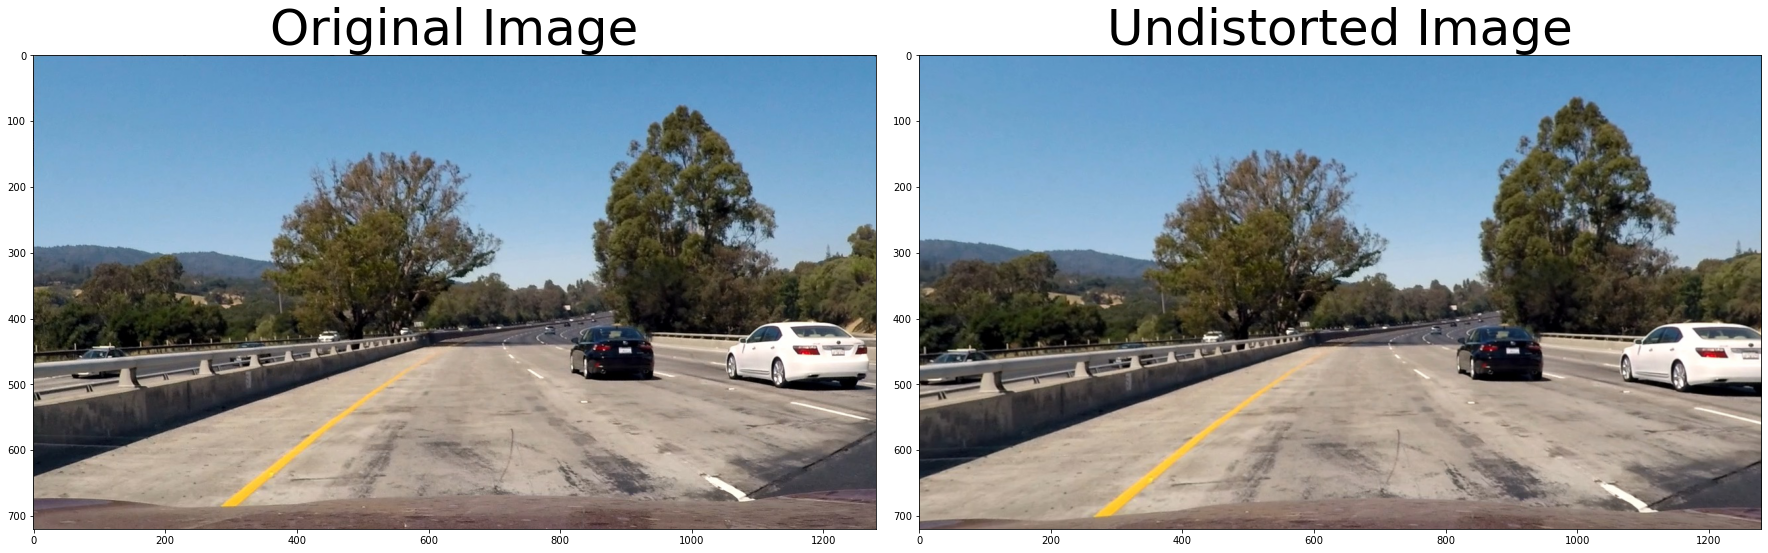

In [3]:
test_files = ['test_images/test1.jpg']
# undistort
for file in test_files:
    img = mpimg.imread(file)
    img_undistorted = cal_undistort(img, mtx, dist)
    show_images(img, img_undistorted, 'Original Image', 'Undistorted Image', 'road_scene_undistort')

## Create thresholded binary image

I created thresholded binary image that can visualize the lane line clearly from images

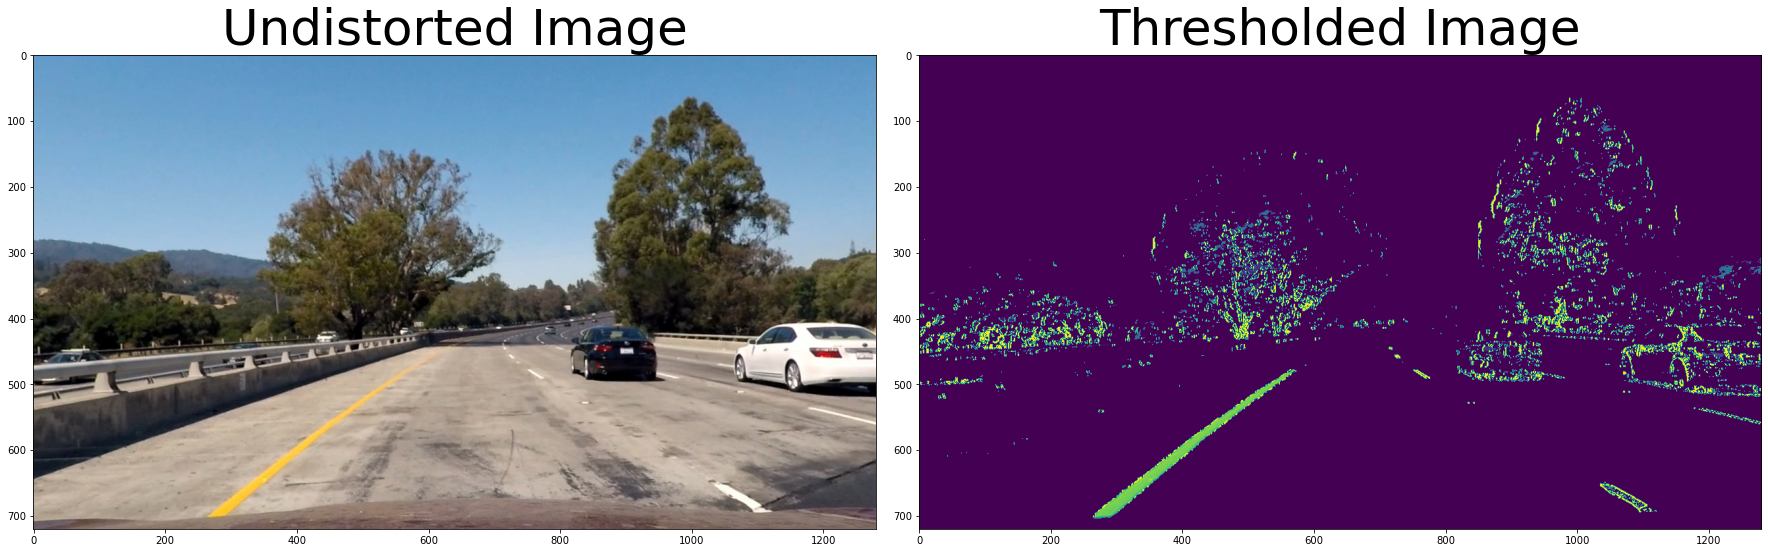

In [4]:
img_thresholded = threshold_combined(img_undistorted)[:,:,0]
show_images(img_undistorted, img_thresholded, 'Undistorted Image', 'Thresholded Image', 'img_pipeline_thresholded', True)

## Apply perspective transform

In [5]:
# use perspective transform
src_mat = np.float32([[190, 720],
                      [577, 460],
                      [705, 460],
                      [1127, 720]])
dst_mat = np.float32([[320, 720],
                      [320, 0],
                      [960, 0],
                      [960, 720]])

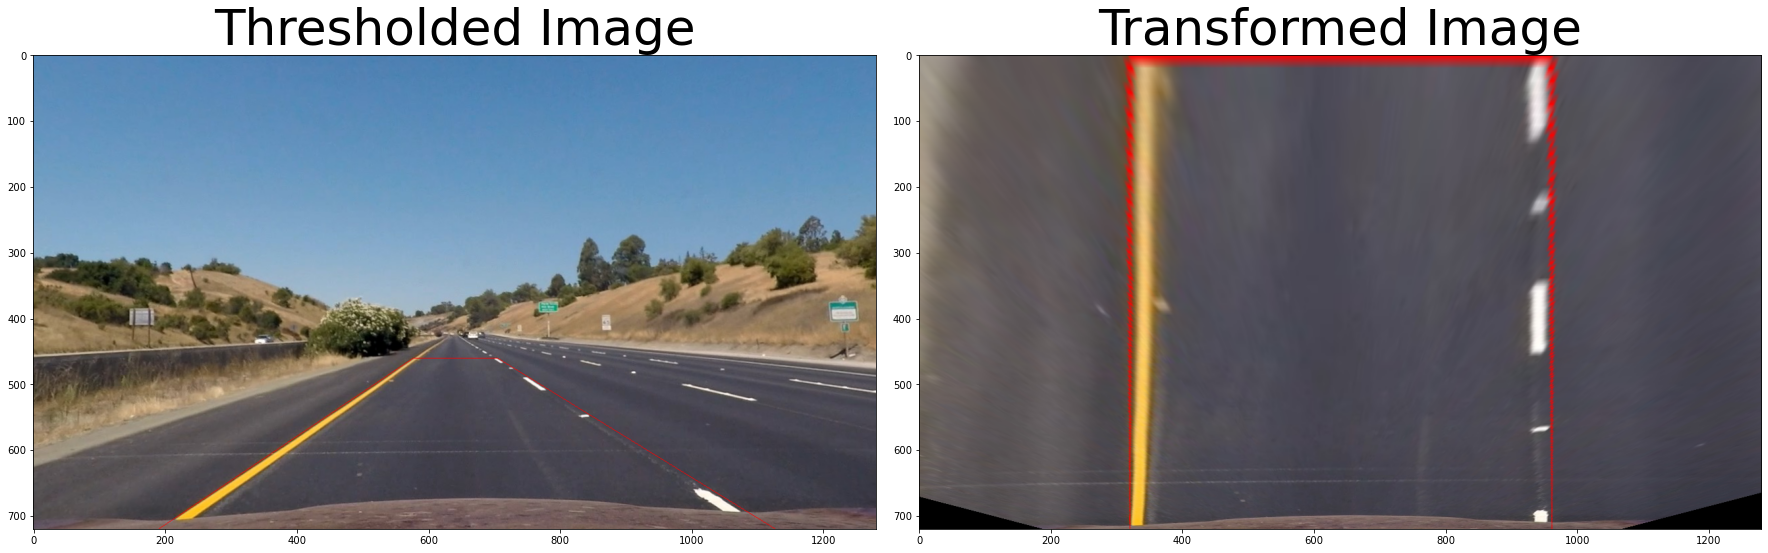

In [6]:
img_pt = mpimg.imread('test_images/straight_lines1.jpg')
img_undistorted_pt = cal_undistort(img_pt, mtx, dist)
src_mat_int = src_mat.astype('int32')
cv2.polylines(img_undistorted_pt, [src_mat_int], True, (255,0,0), 1)
img_transformed_pt = perspective_transform(img_undistorted_pt, src_mat, dst_mat)
show_images(img_undistorted_pt, img_transformed_pt, 'Thresholded Image', 'Transformed Image', 'img_pipeline_perspective_transformed', True)

Apply Thresholding into 

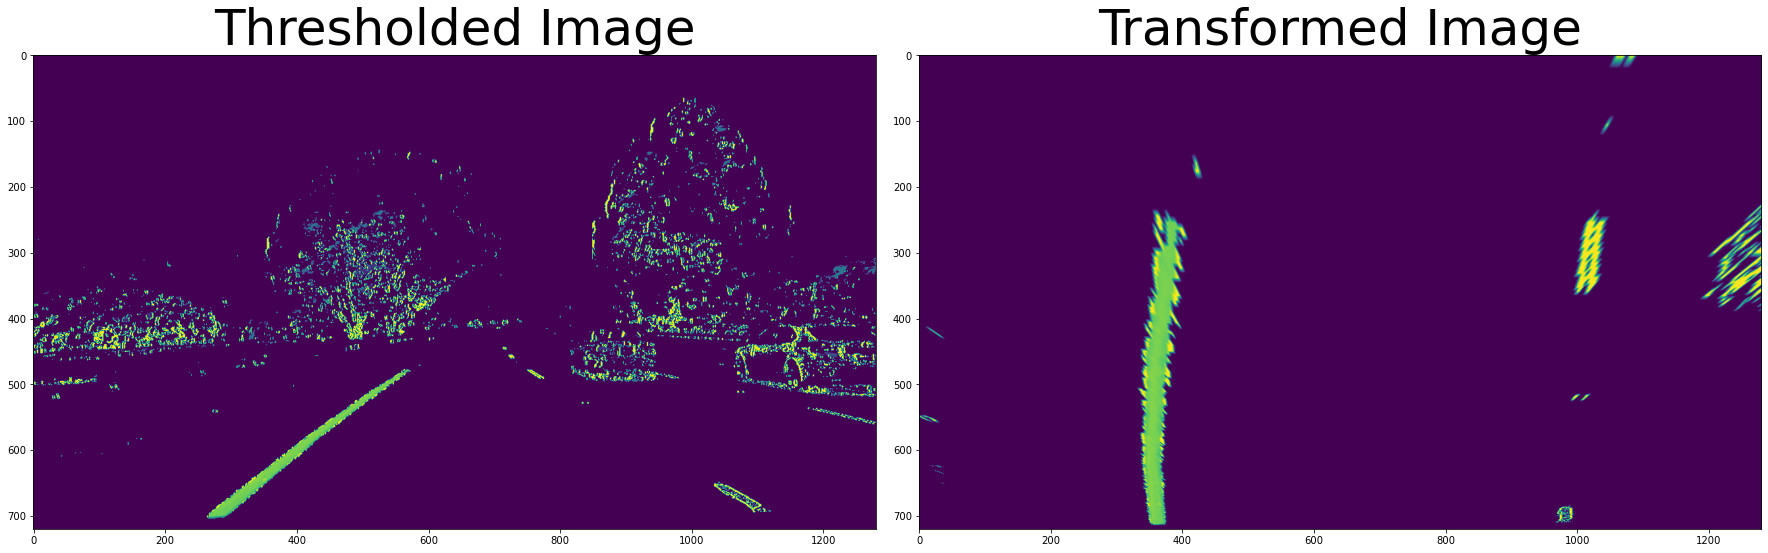

In [7]:
# test image with straight line
img_transformed = perspective_transform(img_thresholded, src_mat, dst_mat)
show_images(img_thresholded, img_transformed, 'Thresholded Image', 'Transformed Image', 'img_pipeline_perspective_transformed', True)

## Find lane pixels and fit to find the lane boundary

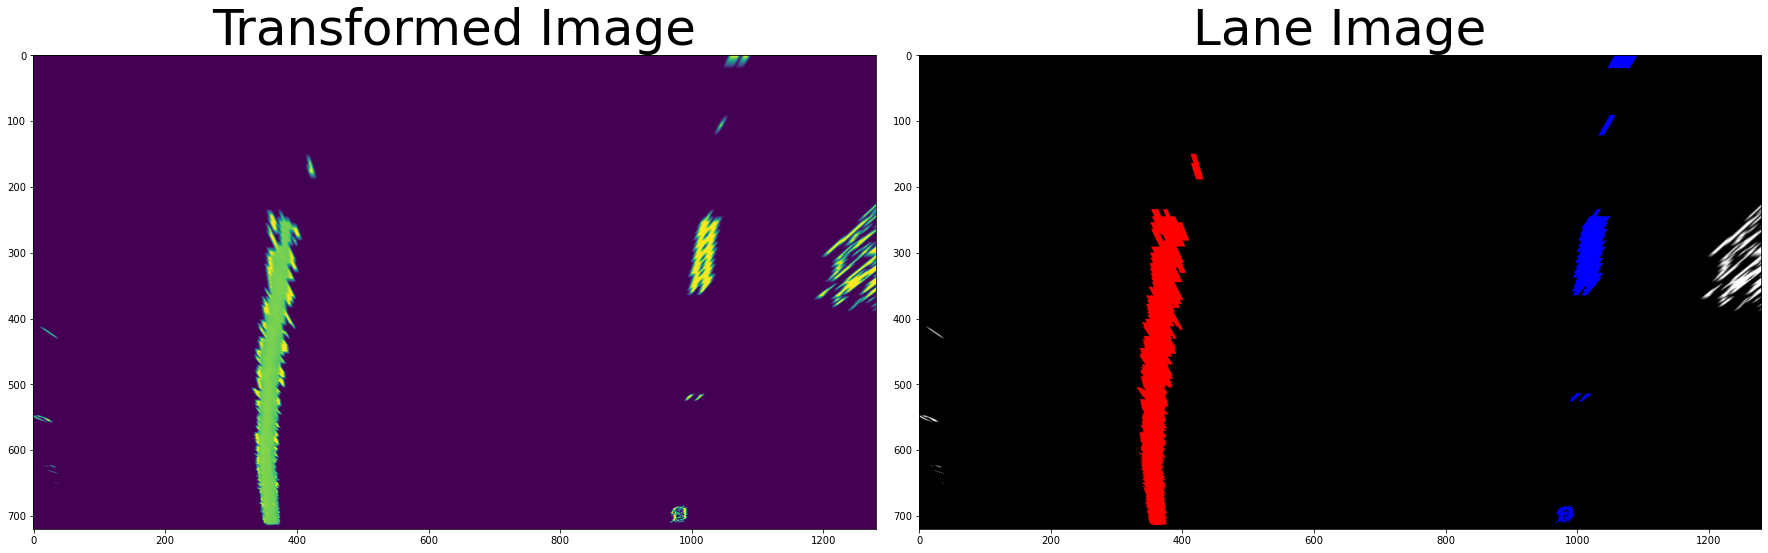

In [8]:
# Load our image
binary_warped = img_transformed
out_img, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, output=True)
show_images(binary_warped, out_img, 'Transformed Image', 'Lane Image', 'road_scene_transformed')

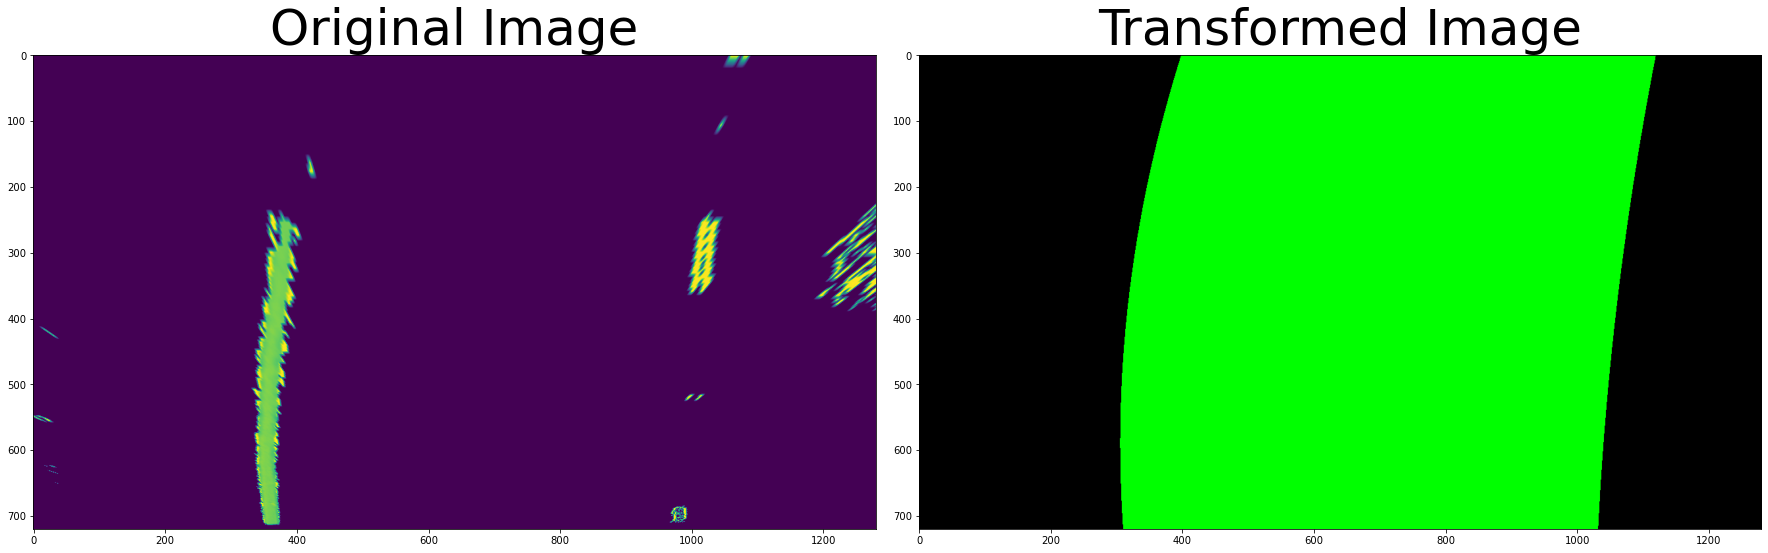

In [9]:
result, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit)
# Load our image
show_images(binary_warped, result, 'Original Image', 'Transformed Image', 'road_scene_transformed')

## Determine the curvature of the lane and vehicle position with respect to center

In [10]:
# Calculate the radius of curvature in meters for both lane lines
curvature = measure_curvature_real(leftx, rightx, lefty, righty)

print(curvature, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

1122.9141248183878 m


# Warp the detected lane foundaries back onto the original image

In [11]:
warped = perspective_transform(result, dst_mat ,src_mat)

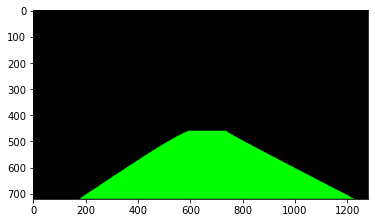

In [12]:
plt.imshow(warped)

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

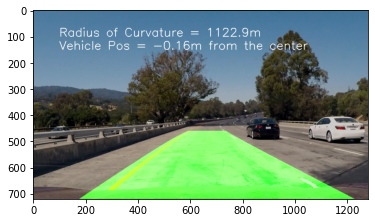

In [13]:
img_combined = weighted_img(warped, img)

# Calculate the radius of curvature in meters for both lane lines
curvature = measure_curvature_real(leftx, rightx, lefty, righty)
vehicle_pos = get_vehicle_pos(warped, left_fit, right_fit)
img_info = put_info_to_img(img_combined, curvature, vehicle_pos)

plt.imshow(img_info)

# Image Pipeline 

In [14]:
def threshold_img(image):
    img_undistorted = cal_undistort(image, mtx, dist)
    img_thresholded = threshold_combined(img_undistorted)
    return img_thresholded

In [20]:
def process_img(image):
    left_fit = []
    right_fit = []
    leftx = []
    lefty = []
    rightx = []
    righty = []
    dict_points = dict()
    ploty = 0
    
    img_undistorted = cal_undistort(image, mtx, dist)
    img_thresholded = threshold_combined(img_undistorted)
    img_binary_warped = perspective_transform(img_thresholded, src_mat, dst_mat)
    if(len(left_fit) == 0):
        out_img, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(img_binary_warped)
    else:
        # search_around_poly if the lanes found on the previous frame
        out_img, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = search_around_poly(img_binary_warped, left_fit, right_fit)
    
    # Visualize lane from the left and right points
    img_lane = visualize_lane(img_binary_warped, left_fitx, right_fitx, ploty)
    img_lane_warped = perspective_transform(img_lane, dst_mat, src_mat)
    
    # Calculate the radius of curvature in meters for both lane lines
    curvature = measure_curvature_real(leftx, rightx, lefty, righty)
    vehicle_pos = get_vehicle_pos(img_lane_warped, left_fit, right_fit)
    
    # combine information acquired
    img_combined = weighted_img(img_lane_warped, image, 1, 0.3)
    img_info = put_info_to_img(img_combined, curvature, vehicle_pos)
    return img_info

In [21]:
test_output = 'test_videos_output/project_video.mp4'
clip_test = VideoFileClip("project_video.mp4")
test_out = clip_test.fl_image(process_img) #NOTE: this function expects color images!!
%time test_out.write_videofile(test_output, audio=False)

fitting left is failed [] []
fitting right is failed [] []


error: OpenCV(4.4.0) /tmp/pip-req-build-kne9u3r2/opencv/modules/core/src/array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'scalarToRawData'


In [19]:
test_videos_name = ['project_video.mp4','challenge_video.mp4','harder_challenge_video.mp4']

In [18]:
test_video_name = test_videos_name[1]
test_output = 'test_videos_output/{0}.mp4'.format(test_video_name.split('.')[0])
clip_test = VideoFileClip(test_video_name)
test_out = clip_test.fl_image(threshold_combined) #NOTE: this function expects color images!!
%time test_out.write_videofile(test_output, audio=False)

NameError: name 'test_videos_name' is not defined

In [106]:
test_video_name = test_videos_name[1]
test_output = 'test_videos_output/{0}.mp4'.format(test_video_name.split('.')[0])
clip_test = VideoFileClip(test_video_name)
test_out = clip_test.fl_image(process_img) #NOTE: this function expects color images!!
%time test_out.write_videofile(test_output, audio=False)

t:   1%|          | 3/485 [00:00<00:28, 17.06it/s, now=None]

Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4



t:   1%|▏         | 7/485 [00:00<00:27, 17.68it/s, now=None]

fitting right is failed {0} {0} [] []


TypeError: expected non-empty vector for x

In [113]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_name))

In [112]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [109]:
test_video_name = test_videos_name[2]
test_output = 'test_videos_output/{0}_thresholding.mp4'.format(test_video_name.split('.')[0])
clip_test = VideoFileClip(test_video_name)
test_out = clip_test.fl_image(threshold_combined) #NOTE: this function expects color images!!
%time test_out.write_videofile(test_output, audio=False)

t:   0%|          | 5/1199 [00:00<00:26, 45.34it/s, now=None]

Moviepy - Building video test_videos_output/harder_challenge_video_thresholding.mp4.
Moviepy - Writing video test_videos_output/harder_challenge_video_thresholding.mp4




t:   2%|▏         | 8/485 [03:55<00:26, 17.68it/s, now=None]    

Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video_thresholding.mp4
CPU times: user 1min, sys: 24 s, total: 1min 24s
Wall time: 36.8 s


In [107]:
test_video_name = test_videos_name[2]
test_output = 'test_videos_output/{0}.mp4'.format(test_video_name.split('.')[0])
clip_test = VideoFileClip(test_video_name)
test_out = clip_test.fl_image(process_img) #NOTE: this function expects color images!!
%time test_out.write_videofile(test_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/harder_challenge_video.mp4.
Moviepy - Writing video test_videos_output/harder_challenge_video.mp4




t:   2%|▏         | 8/485 [01:42<00:26, 17.68it/s, now=None]    

Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video.mp4
CPU times: user 3min 58s, sys: 1min 45s, total: 5min 44s
Wall time: 1min 33s


In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))